# Ground Truth Generation (Initial Captures)

This notebook generates ground truth maps using a simple watershed algorithm and user input, it will generate 

In [178]:
from spectral import *
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pickle
import os
from os.path import exists
from matplotlib import cm

In [179]:
dir_fn = "processed-data/sardi-capture-final/final/reflectance/2023_03_28/food_and_waste"
dir_fn = "processed-data/sardi-capture-final/final/reflectance/2023_03_28/just_waste"

In [180]:
dir_cont = os.listdir(dir_fn)

data_cubes = [cont for cont in dir_cont if '.nc' in cont]
print(sorted(data_cubes))

['2023_03_28-01_45_56.nc', '2023_03_28-01_48_52.nc', '2023_03_28-01_51_30.nc', '2023_03_28-01_54_05.nc', '2023_03_28-01_56_37.nc', '2023_03_28-01_58_54.nc']


In [226]:
# make sure to use radiance, for some reason reflectance doesn't work properly
fn = "2023_03_28-01_58_54.nc"
fn_path = dir_fn + '/' + fn
gnd_t_fn = fn_path.replace('radiance','reflectance').split('.')[0] + "-gnd_t.pkl"

In [227]:
def process_into_rgb(loc_ds):
    """
    Processes a given dataset into an rgb image for display
    """
    loc_dc = np.array(loc_ds['datacube']).transpose(1,2,0)
    loc_binned_wavelengths = np.array(loc_ds['wavelength'])

    red_nm = 640
    green_nm = 550
    blue_nm = 470
    
    rgb = np.zeros( (*loc_dc.shape[:2],3), dtype=np.float32)
    rgb[...,0] = loc_dc[:,:,np.argmin(np.abs(loc_binned_wavelengths-red_nm))]
    rgb[...,1] = loc_dc[:,:,np.argmin(np.abs(loc_binned_wavelengths-green_nm))]
    rgb[...,2] = loc_dc[:,:,np.argmin(np.abs(loc_binned_wavelengths-blue_nm))]
    
    rgb = np.minimum(np.maximum(rgb, 0), 1)

    rgb *= 255
    rgb = rgb.astype(np.uint8)
    
    return rgb

In [228]:
ds = nc.Dataset(fn_path.replace("reflectance","radiance"))

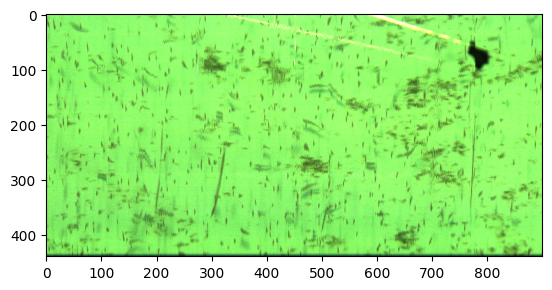

In [229]:
image = process_into_rgb(ds)
plt.imshow(image)
plt.imsave(fn_path.replace('.nc','-rgb.png'), image)

In [230]:
# force recreation of ground truth files
force = True

In [231]:
cv.imshow("Original", cv.imread(fn_path.replace('radiance','reflectance').split('.')[0] + ".png"))

def create_rgb(i):
    return tuple(np.array(cm.tab10(i)[:3])*255)

drawing=False # true if mouse is pressed
mode=True

# def on_click(event,x,y,flags,params):
#     global marks_updated

#     if event == cv.EVENT_LBUTTONDOWN:                         
#         # add mark to image that gets passed to the watershed algo
#         cv.circle(marker_img,(x,y),2,(current_marker),-1) 

#         # add mark to image for user to see
#         cv.circle(img_copy,(x,y),2,colors[current_marker],-1)

#         marks_updated = True 

def on_click(event,former_x,former_y,flags,param):
    global current_former_x,current_former_y,drawing, mode, marks_updated
    
    if event==cv.EVENT_LBUTTONDOWN:
        drawing=True
        current_former_x,current_former_y=former_x,former_y
    elif event==cv.EVENT_MOUSEMOVE:
        if drawing==True:
            if mode==True:
                cv.line(marker_img,(current_former_x,current_former_y),(former_x,former_y),(current_marker),2)
                cv.line(img_copy,(current_former_x,current_former_y),(former_x,former_y),colors[current_marker],2)
                current_former_x = former_x
                current_former_y = former_y
                marks_updated = True 
    elif event==cv.EVENT_LBUTTONUP:
        drawing=False
        if mode==True:
            cv.line(marker_img,(current_former_x,current_former_y),(former_x,former_y),(current_marker),2)
            cv.line(img_copy,(current_former_x,current_former_y),(former_x,former_y),colors[current_marker],2)
            current_former_x = former_x
            current_former_y = former_y
            marks_updated = True 
    return former_x,former_y

if not exists(gnd_t_fn) or force:
    img_copy=np.copy(image)
    marker_img=np.zeros(image.shape[:2],dtype=np.int32)
    segments = np.zeros(image.shape,dtype=np.uint8)
    ground_truth = np.zeros(image.shape[:2],dtype=np.uint8)

    cm.tab10(0)

    colors = []
    for i in range(10):
        colors.append(create_rgb(i))
        
    colors[1]=(0,0,0)
    
    n_marker = 9
    current_marker = 1
    marks_updated = False

    # create display window
    cv.namedWindow('Image')
    cv.setMouseCallback('Image', on_click)

    while True:
        
        cv.imshow('Watershed segments',segments)
        cv.imshow('Image',img_copy)

        k = cv.waitKey(1)

        # jump out of loop and close all windows with ESC
        if k == 27:
            break

        # clear the images with c
        elif k == ord('c'):
            img_copy = image.copy()
            marker_img = np.zeros(image.shape[:2],dtype = np.int32)
            segments = np.zeros(image.shape,dtype = np.uint8) 

        # update the colour choice, keys [1-9] 
        elif k > 0 and chr(k).isdigit():
            current_marker = int(chr(k))

        # update the watershed fill based on the marks
        if marks_updated:
            marker_img_copy = marker_img.copy()
            cv.watershed(image,marker_img_copy)
            segments = np.zeros(image.shape,dtype = np.uint8)
            
            for color_ind in range(n_marker):
                segments[marker_img_copy == (color_ind)] = colors[color_ind]
                ground_truth[marker_img_copy == (color_ind)] = color_ind

    # close all windows
    cv.destroyAllWindows()

In [232]:
# save ground truth for future use
with open(gnd_t_fn, 'wb') as out_file:
    pickle.dump(ground_truth, out_file)
    
plt.imsave(gnd_t_fn.split('.')[0]+'.png', ground_truth)